In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

import tensorflow_hub as hub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#EffcientNet-b4
res_url = 'https://tfhub.dev/tensorflow/efficientnet/lite4/classification/2'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(res_url,trainable=False)])

In [14]:
expect_img_size = 528

feature_model.build([None, expect_img_size, expect_img_size, 3])
feature_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1000)              13118936  
Total params: 13,118,936
Trainable params: 0
Non-trainable params: 13,118,936
_________________________________________________________________


In [15]:
feature_model.save('/content/drive/My Drive/efficientnet_feature.h5')

In [16]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 528
batch_size = 32

# 학습 및 검증 데이터용 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#검증데이터
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/audio_predict/train_image_data',
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/audio_predict/train_image_data',
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

Found 1323 images belonging to 2 classes.
Found 441 images belonging to 2 classes.


In [ ]:
valid_generator.class_indices

{'0': 0, '1': 1}

In [17]:
# 이미지 보강 2배
import numpy as np
from tqdm import tqdm

image_size = 500
batch_size = 32

batch_step = (1764 * 2) // batch_size #데이터 증폭 시켜 배치 스텝구하기
train_features = [] 
train_Y = [] 

for idx in tqdm(range(batch_step)):
  x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)
print(train_Y)

100%|██████████| 110/110 [06:42<00:00,  3.66s/it]

(3478, 1000)
(3478, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [18]:
valid_features = [] 
valid_Y = [] 

for idx in tqdm(range(valid_generator.n)):
  x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

100%|██████████| 441/441 [02:22<00:00,  3.09it/s]

(441, 1000)
(441, 2)


In [19]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256, activation= 'relu', input_shape = (1000,)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(2,activation='softmax')
])
model.compile(tf.optimizers.RMSprop(0.0001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 256,770
Trainable params: 256,770
Non-trainable params: 0
_________________________________________________________________


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/My Drive/check.h5'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)

es = EarlyStopping(patience=50, verbose=1)
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 100,
                    batch_size = 32,
                    callbacks=[es,cp])
model.summary()

Epoch 1/100
 93/109 [========================>.....] - ETA: 0s - loss: 0.2872 - accuracy: 0.8794
Epoch 00001: val_accuracy improved from -inf to 0.96372, saving model to /content/drive/My Drive/check.h5
109/109 [==============================] - 0s 5ms/step - loss: 0.2664 - accuracy: 0.8899 - val_loss: 0.1215 - val_accuracy: 0.9637
Epoch 2/100
 94/109 [========================>.....] - ETA: 0s - loss: 0.1120 - accuracy: 0.9611
Epoch 00002: val_accuracy improved from 0.96372 to 0.97052, saving model to /content/drive/My Drive/check.h5
109/109 [==============================] - 0s 3ms/step - loss: 0.1081 - accuracy: 0.9623 - val_loss: 0.0918 - val_accuracy: 0.9705
Epoch 3/100
 94/109 [========================>.....] - ETA: 0s - loss: 0.0709 - accuracy: 0.9754
Epoch 00003: val_accuracy improved from 0.97052 to 0.97732, saving model to /content/drive/My Drive/check.h5
109/109 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.9747 - val_loss: 0.0748 - val_accuracy:

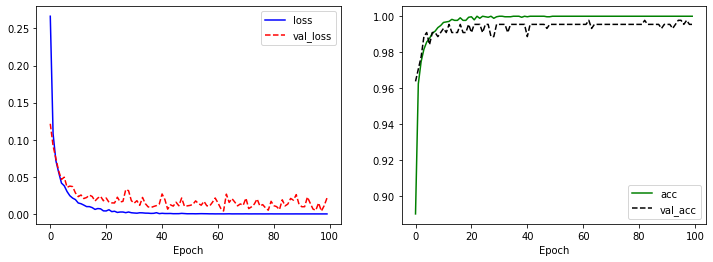

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [22]:
results = model.evaluate(valid_features, valid_Y)
print('Test accuracy: ', results[1])

14/14 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9955
Test accuracy:  0.9954648613929749


In [23]:
model.save('/content/drive/My Drive/efficientnet_audio_500.h5')

In [ ]:
print('i')

i
